Samples shape: (2062, 64, 64)
Labels shape: (2062, 10)

Training shape: (1752, 64, 64)
1752 sample, 64 x 64 size grayscale image.



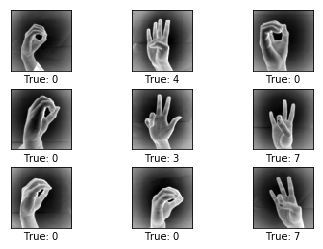

Test shape: (310, 64, 64)
310 sample, 64 x 64 size grayscale image.



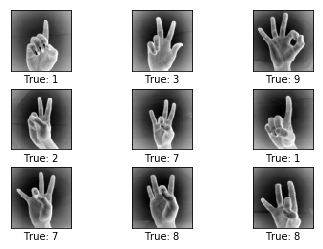

In [8]:
# Configura conjuntos de treinamento e teste 
# X_train, X_test, Y_train, Y_test
%run './functions/SLD-LoadTrainTestSets.ipynb'

In [9]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Model, Input
from keras.applications.mobilenet import MobileNet
from keras.layers import Conv2D, GlobalAveragePooling2D, Reshape
from keras.optimizers import Adam

In [10]:
X_train = np.array(resize_npy_images(X_train, (128, 128)))
X_test = np.array(resize_npy_images(X_test, (128, 128)))

In [11]:
print('Training shape:', X_train.shape[0], 'sample,',X_train.shape[1] ,'x',X_train.shape[2] ,'size grayscale image.\n')
print('Test shape:', X_test.shape[0], 'sample,',X_test.shape[1] ,'x',X_test.shape[2] ,'size grayscale image.\n')

Training shape: 1752 sample, 128 x 128 size grayscale image.

Test shape: 310 sample, 128 x 128 size grayscale image.



In [12]:
original_input_shape = (128, 128, 3)
desired_input_shape = (128, 128, 1)
layer_name = 'conv1'

weights = None
include_top = False

adam_lr = 0.0001
nb_epochs = 10
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
validation_split = 0.1
batch_size=10

---

# Rede sem pesos ImageNet e sem Include top

In [14]:
base_model = MobileNet(input_shape=original_input_shape,
                       weights=weights,
                       include_top=include_top)
base_model.layers[-1].name

'conv_pw_13_relu'

In [15]:
# Alterando input para grayscale (1 channel)
selected_layer = base_model.get_layer(layer_name)
selected_layer_index = base_model.layers.index(selected_layer)

w = selected_layer.get_weights()
w[0] = w[0].mean(axis=2, keepdims=True)

y = x = Input(shape=desired_input_shape)

attributes = dict(selected_layer.get_config(),
                  name=layer_name + '_1',
                  weights=w)
selected_layer = Conv2D.from_config(attributes)

y = selected_layer(y)

for layer in base_model.layers[selected_layer_index + 1:]:
    y = layer(y)

In [16]:
# Adicionando camadas representadas pelo include_top=True
# camada FC no final da rede
y = GlobalAveragePooling2D()(y)
y = Reshape((1, 1, 1024))(y)
y = Dropout(0.25)(y)
y = Conv2D(10, kernel_size=(1, 1), activation='relu')(y)
y = Activation('softmax')(y)
y = Reshape((10,))(y)

In [17]:
model = Model(inputs=x, outputs=y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

In [ ]:
# Congela camadas
# for layer in model.layers:
#     layer.trainable = False

In [19]:
expand_train_X = np.expand_dims(X_train, axis=-1)
expand_test_X = np.expand_dims(X_test, axis=-1)

Train on 1576 samples, validate on 176 samples
Epoch 1/10
1576/1576 [==============================] - 198s 126ms/step - loss: 2.2983 - acc: 0.1212 - val_loss: 2.8720 - val_acc: 0.1193
Epoch 2/10
1576/1576 [==============================] - 194s 123ms/step - loss: 2.2054 - acc: 0.2011 - val_loss: 2.5206 - val_acc: 0.1761
Epoch 3/10
1576/1576 [==============================] - 192s 122ms/step - loss: 2.0420 - acc: 0.2855 - val_loss: 2.2142 - val_acc: 0.1932
Epoch 4/10
1576/1576 [==============================] - 191s 121ms/step - loss: 1.8725 - acc: 0.3579 - val_loss: 2.8875 - val_acc: 0.2216
Epoch 5/10
1576/1576 [==============================] - 192s 122ms/step - loss: 1.7112 - acc: 0.4201 - val_loss: 1.7458 - val_acc: 0.4148
Epoch 6/10
1576/1576 [==============================] - 193s 122ms/step - loss: 1.4241 - acc: 0.5317 - val_loss: 1.4814 - val_acc: 0.5341
Epoch 7/10
1576/1576 [==============================] - 195s 124ms/step - loss: 1.1333 - acc: 0.6555 - val_loss: 1.3183 - val

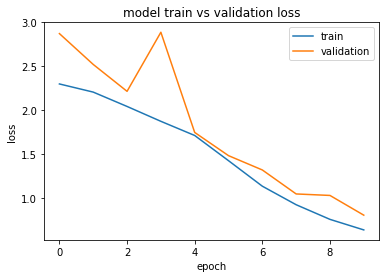

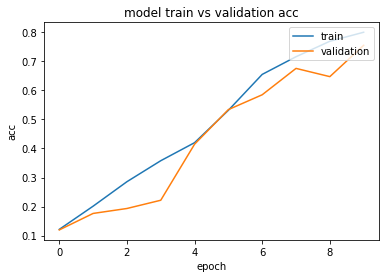

Acertos: 218 / 310
Confusion matrix, without normalization
[[32  0  0  0  0  0  0  0  0  0]
 [ 1 20  2  0  0  0  0  1  0  0]
 [ 0  3 24  0  0  0  0  6  1  0]
 [ 0  0  0 26  0  4  0  0  0  0]
 [ 0  0  1  0 16  0  0 10  2  1]
 [ 0  0  0  2  1 28  0  0  2  2]
 [ 0  0 10  2  6  0  0  9  0  1]
 [ 1  0  2  1  0  0  0 25 11  2]
 [ 0  0  1  0  1  0  0  1 23  2]
 [ 0  0  0  0  0  1  0  0  2 24]]
CPU times: user 1h 42min 7s, sys: 10min 8s, total: 1h 52min 16s
Wall time: 32min 41s


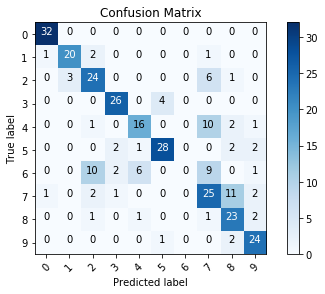

In [20]:
%%time
acertos, pred = execute_model(model, expand_train_X, Y_train, expand_test_X, Y_test,
                              validation_split, batch_size, cm_plot_labels, 
                              adam_lr, nb_epochs)

---

# Rede com pesos ImageNet e com Include top

In [21]:
weights = 'imagenet'
include_top = True

In [22]:
base_model = MobileNet(input_shape=original_input_shape,
                       weights=weights,
                       include_top=include_top)
base_model.layers[-1].name

17227776/17225924 [==============================] - 4s 0us/step


'reshape_2'

In [25]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

In [26]:
# Alterando input para grayscale (1 channel)
selected_layer = base_model.get_layer(layer_name)
selected_layer_index = base_model.layers.index(selected_layer)

w = selected_layer.get_weights()
w[0] = w[0].mean(axis=2, keepdims=True)

y = x = Input(shape=desired_input_shape)

attributes = dict(selected_layer.get_config(),
                  name=layer_name + '_1',
                  weights=w)
selected_layer = Conv2D.from_config(attributes)

y = selected_layer(y)

for layer in base_model.layers[selected_layer_index + 1:-4]:
    y = layer(y)

In [27]:
# Adicionando camadas representadas pelo include_top=True
# camada FC no final da rede
# y = GlobalAveragePooling2D()(y)
# y = Reshape((1, 1, 1024))(y)
y = Dropout(0.25)(y)
y = Conv2D(10, kernel_size=(1, 1), activation='relu')(y)
y = Activation('softmax')(y)
y = Reshape((10,))(y)

In [28]:
model = Model(inputs=x, outputs=y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

In [ ]:
# Congela camadas
# for layer in model.layers:
#     layer.trainable = False

In [29]:
expand_train_X = np.expand_dims(X_train, axis=-1)
expand_test_X = np.expand_dims(X_test, axis=-1)

Train on 1576 samples, validate on 176 samples
Epoch 1/10
1576/1576 [==============================] - 201s 127ms/step - loss: 1.0037 - acc: 0.6859 - val_loss: 0.2673 - val_acc: 0.9205
Epoch 2/10
1576/1576 [==============================] - 193s 122ms/step - loss: 0.2201 - acc: 0.9378 - val_loss: 0.1139 - val_acc: 0.9659
Epoch 3/10
1576/1576 [==============================] - 191s 121ms/step - loss: 0.0774 - acc: 0.9810 - val_loss: 0.0786 - val_acc: 0.9716
Epoch 4/10
1576/1576 [==============================] - 191s 121ms/step - loss: 0.0430 - acc: 0.9918 - val_loss: 0.0454 - val_acc: 0.9886
Epoch 5/10
1576/1576 [==============================] - 197s 125ms/step - loss: 0.0211 - acc: 0.9962 - val_loss: 0.0344 - val_acc: 0.9886
Epoch 6/10
1576/1576 [==============================] - 203s 129ms/step - loss: 0.0162 - acc: 0.9968 - val_loss: 0.0409 - val_acc: 0.9886
Epoch 7/10
1576/1576 [==============================] - 196s 124ms/step - loss: 0.0147 - acc: 0.9987 - val_loss: 0.0330 - val

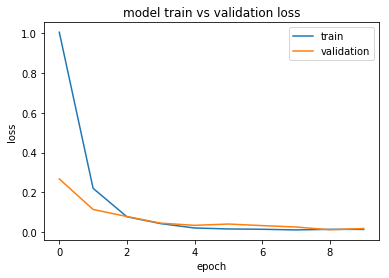

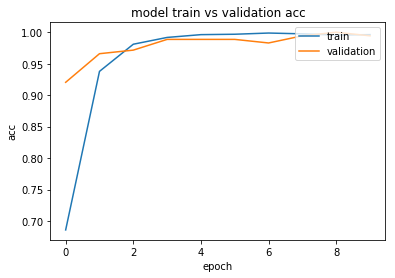

Acertos: 307 / 310
Confusion matrix, without normalization
[[32  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  0  0]
 [ 0  0 34  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 35  0  0  0  0]
 [ 0  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0 40  2  0]
 [ 0  0  0  0  0  0  0  1 27  0]
 [ 0  0  0  0  0  0  0  0  0 27]]
CPU times: user 1h 42min 25s, sys: 10min 12s, total: 1h 52min 38s
Wall time: 32min 52s


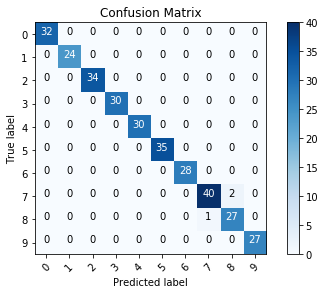

In [30]:
%%time
acertos, pred = execute_model(model, expand_train_X, Y_train, expand_test_X, Y_test,
                              validation_split, batch_size, cm_plot_labels, 
                              adam_lr, nb_epochs)

---

In [31]:
307/310

0.9903225806451613